# CS 145 COVID Prediction

## Loading Data

First we need to load the data, which is stored in CSV files separated by date

In [2]:
import numpy as np
import pandas as pd
import glob
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [3]:
# grab filepaths for every csv file
datapath = 'data/csse_covid_19_daily_reports_us/*.csv'
datafiles = np.array(glob.glob(datapath))
print(datafiles[138:142])

['data/csse_covid_19_daily_reports_us\\08-28-2020.csv'
 'data/csse_covid_19_daily_reports_us\\08-29-2020.csv'
 'data/csse_covid_19_daily_reports_us\\08-30-2020.csv'
 'data/csse_covid_19_daily_reports_us\\08-31-2020.csv']


In [4]:
# init giant df
data = pd.read_csv(datafiles[0])
# read and append each csv to the master df
for i in range(1, len(datafiles)):
    df = pd.read_csv(datafiles[i])
    data = data.append(df, ignore_index = True)
# only keep 50 states
data.drop(data[data.Province_State.isin(['Diamond Princess', 'District of Columbia', 'Grand Princess', 'Guam', 'Puerto Rico', 'American Samoa', 'Northern Mariana Islands', 'Recovered', 'Virgin Islands'])].index, inplace = True)
data.drop(columns = ['Country_Region', 'FIPS', 'UID', 'ISO3'], inplace = True)
data['Last_Update'] = data['Last_Update'].astype('datetime64[ns]')
data = data.reset_index(drop=True)
data.loc[48:52, ]

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
48,Wisconsin,2020-04-12 23:18:15,44.2685,-89.6165,3341,144,NaN,3197.0,64.565739,39257.0,974.0,4.310087,758.652263,29.152948
49,Wyoming,2020-04-12 23:18:15,42.7560,-107.3025,270,0,137.0,270.0,54.299735,5459.0,40.0,0.000000,1097.860188,14.814815
50,Alabama,2020-04-13 23:07:54,32.3182,-86.9023,3734,99,NaN,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886
51,Alaska,2020-04-13 23:07:54,61.3707,-152.4044,277,8,85.0,269.0,46.340521,7830.0,32.0,2.888087,1309.914362,11.552347
52,Arizona,2020-04-13 23:07:54,33.7298,-111.4312,3705,122,NaN,3583.0,50.901828,43347.0,525.0,3.292848,595.530778,14.170040


## Data Cleaning

In [5]:
data = pd.concat([data, pd.get_dummies(data['Province_State'])], axis = 1)
statenames = np.unique(data['Province_State'])
#data.drop(columns = ['Province_State'], inplace = True)
names = list(data.columns.values)
timestamps = data['Last_Update']
states = data['Province_State']
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470.0,75.988020,21583.0,...,0,0,0,0,0,0,0,0,0,0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,45.504049,8038.0,...,0,0,0,0,0,0,0,0,0,0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,48.662422,42109.0,...,0,0,0,0,0,0,0,0,0,0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,49.439423,19722.0,...,0,0,0,0,0,0,0,0,0,0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155.0,58.137726,190328.0,...,0,0,0,0,0,0,0,0,0,0


We impute NA values using KNN with k = 10.

In [6]:
imputer = KNNImputer(n_neighbors=10, weights="uniform")
data = pd.DataFrame(data = imputer.fit_transform(data.drop(columns = ['Province_State', 'Last_Update'])), columns = names[2:])
data = pd.concat([states, timestamps, data], axis = 1)
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3563.0,93.0,780.3,3470.0,75.988020,21583.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Additional Features

We will hard code each state's overall political stance in 2020, with 3 indicating safe, 2 indicating likely, 1 indicating leaning, and 0 indicating none. Thus the parameters "dem" and "rep" are ordinal while "swing" is a dummy variable. Because Maine and Nebraska allow split voting, we will consider Maine likely democratic and Nebraska likely republican. The source of the data is from https://www.270towin.com/

We will also include whether a state has enacted a mandatory mask mandate, the data for which is from [Axios](https://www.axios.com/states-face-coverings-mandatory-a0e2fe35-5b7b-458e-9d28-3f6cdb1032fb.html). This will be dummy coded.

In [7]:
dem = [0, 0, 1, 0, 3, 2, 3, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 0, 1, 1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 0, 3, 2, 3, 0, 1, 0]
rep = [3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 2, 3, 3, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 3, 0, 3]
swing = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mask = [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]

In [8]:
# repeats an array, e.gg [1,2,3] 2 times is [1,2,3,1,2,3]
def repeat(dat, times):
    temp = dat
    for i in range(int(times) - 1):
        temp = np.append(temp, dat)
    return temp

times = data.shape[0] / 50
data['dem'] = repeat(dem, times)
data['rep'] = repeat(rep, times)
data['swing'] = repeat(swing, times)
data['mask'] = repeat(mask, times)

In [9]:
data_sort = data[['Province_State', 'Last_Update', 'Confirmed']].sort_values(by = ['Province_State', 'Last_Update'])
cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == 'Alabama']
new = data_sort['Confirmed'].loc[data_sort['Province_State'] == 'Alabama']
new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == 'Alabama'].index)
df = pd.concat([cols, data_sort['Confirmed'].loc[data_sort['Province_State'] == 'Alabama'] - new], axis = 1)
df.columns.values[2] = 'New_Confirmed'

for state in statenames[1:len(statenames)]:
    cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == state]
    new = data_sort['Confirmed'].loc[data_sort['Province_State'] == state]
    new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == state].index)
    temp = pd.concat([cols, data_sort['Confirmed'].loc[data_sort['Province_State'] == state] - new], axis = 1)
    temp.columns.values[2] = 'New_Confirmed'
    df = df.append(temp)

data = pd.concat([data, df.sort_values(by = ['Last_Update', 'Province_State'])[['New_Confirmed']]], axis = 1)      

In [10]:
data_sort = data[['Province_State', 'Last_Update', 'Deaths']].sort_values(by = ['Province_State', 'Last_Update'])
cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == 'Alabama']
new = data_sort['Deaths'].loc[data_sort['Province_State'] == 'Alabama']
new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == 'Alabama'].index)
df = pd.concat([cols, data_sort['Deaths'].loc[data_sort['Province_State'] == 'Alabama'] - new], axis = 1)
df.columns.values[2] = 'New_Deaths'

for state in statenames[1:len(statenames)]:
    cols = data_sort[['Province_State', 'Last_Update']].loc[data_sort['Province_State'] == state]
    new = data_sort['Deaths'].loc[data_sort['Province_State'] == state]
    new = pd.Series(np.append(new.iloc[0], new.iloc[0:len(new) - 1]), index = data_sort.loc[data_sort['Province_State'] == state].index)
    temp = pd.concat([cols, data_sort['Deaths'].loc[data_sort['Province_State'] == state] - new], axis = 1)
    temp.columns.values[2] = 'New_Deaths'
    df = df.append(temp)

data = pd.concat([data, df.sort_values(by = ['Last_Update', 'Province_State'])[['New_Deaths']]], axis = 1)    
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask,New_Confirmed,New_Deaths
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3563.0,93.0,780.3,3470.0,75.988020,21583.0,...,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,...,0.0,0.0,0.0,0.0,0,2,0,0,0.0,0.0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,...,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,...,0.0,0.0,0.0,0.0,3,0,0,1,0.0,0.0


Next we split the data into training and testing sets.

In [11]:
train = data.drop(data[data.Last_Update.astype('datetime64[ns]') > '2020-09-01'].index)
#train.drop(columns = "Last_Update", inplace = True)
test = data.drop(data[(data.Last_Update.astype('datetime64[ns]') <= '2020-09-01')].index)
test.drop(test[(test.Last_Update.astype('datetime64[ns]') > '2020-09-27')].index, inplace = True)
#test.drop(columns = "Last_Update", inplace = True)

In [12]:
train.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask,New_Confirmed,New_Deaths
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3563.0,93.0,780.3,3470.0,75.988020,21583.0,...,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,...,0.0,0.0,0.0,0.0,0,2,0,0,0.0,0.0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,...,0.0,0.0,0.0,0.0,0,3,0,1,0.0,0.0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,...,0.0,0.0,0.0,0.0,3,0,0,1,0.0,0.0


In [13]:
train.to_csv('cleaned_train.csv')
test.to_csv('cleaned_test.csv')

## Auto ARIMA Predictions

Uses a brute force search to find parameters with lowest AIC per state and makes predictions per state.

In [14]:
import datetime
base = datetime.date(2020, 9, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(26)]
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%m/%d/%Y")

Takes a long time

In [23]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
pred = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed'])
# generate a model for each state for Confirmed predictions
for state in statenames:
    # formatting for storing predictions
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    # use stepwise search for arima parameters
    train_con = train_data[['Confirmed']].loc[train_data[state] == 1]
    stepwise_model = auto_arima(train_con.Confirmed, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=12,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    # sequence of all previous data (confirmed cases)
    history = [x for x in train_con.Confirmed]
    predictions = list()
    for t in range(numdays):
        # fit arima on data
        model = ARIMA(history, order = stepwise_model.order)
        model_fit = model.fit()
        # make prediction
        output = model_fit.forecast()
        # append prediction onto previous data 
        predictions.append(output[0])
        history.append(output[0])
    # save state predictions
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed']
    pred = pred.append(temp)


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2007.313, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2067.439, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2022.503, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2007.458, Time=0.11 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2007.385, Time=0.11 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=2009.156, Time=0.98 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=2009.164, Time=1.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2005.828, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2007.283, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2007.365, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2022.867, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=2003.776, Time=0.24 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=2003.131, Time=0.36 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=2005.023, Time=0.96 sec
 ARIMA(1,2,2)(1,0,1

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1224.896, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1233.001, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1232.983, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1223.338, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1221.706, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1223.417, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1208.133, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1209.740, Time=0.13 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1209.685, Time=0.14 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1211.526, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1231.023, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1205.562, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1206.808, Time=0.18 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1206.693, Time=0.16 sec
 ARIMA(2,2,1)(1,0,1

 ARIMA(4,2,2)(0,0,1)[12]             : AIC=1752.136, Time=0.72 sec
 ARIMA(4,2,2)(0,0,0)[12]             : AIC=1750.591, Time=0.36 sec
 ARIMA(4,2,2)(1,0,0)[12]             : AIC=1752.261, Time=0.74 sec
 ARIMA(4,2,2)(1,0,1)[12]             : AIC=1754.122, Time=0.82 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=1776.904, Time=0.22 sec
 ARIMA(4,2,1)(0,0,0)[12]             : AIC=1769.253, Time=0.13 sec
 ARIMA(5,2,2)(0,0,0)[12]             : AIC=1751.737, Time=0.39 sec
 ARIMA(4,2,3)(0,0,0)[12]             : AIC=1754.264, Time=0.39 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=1781.196, Time=0.12 sec
 ARIMA(3,2,3)(0,0,0)[12]             : AIC=1778.552, Time=0.24 sec
 ARIMA(5,2,1)(0,0,0)[12]             : AIC=1767.567, Time=0.06 sec
 ARIMA(5,2,3)(0,0,0)[12]             : AIC=1759.407, Time=0.45 sec
 ARIMA(4,2,2)(0,0,0)[12] intercept   : AIC=1752.306, Time=0.40 sec

Best model:  ARIMA(4,2,2)(0,0,0)[12]          
Total fit time: 17.675 seconds


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\bas

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1922.860, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2006.042, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1945.982, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1922.274, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1920.296, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1922.264, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1917.176, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1918.794, Time=0.13 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1918.927, Time=0.15 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1919.765, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1944.551, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1918.752, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1917.945, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1917.662, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2144.293, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2177.227, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2164.771, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2145.763, Time=0.11 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2146.787, Time=0.09 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=2145.703, Time=0.85 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=2145.468, Time=0.53 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2146.799, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=2143.483, Time=0.31 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=2174.618, Time=0.28 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=2143.147, Time=0.50 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=2144.573, Time=0.16 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=2145.040, Time=0.84 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=2143.387, Time=0.52 sec
 ARIMA(1,2,0)(0,0,2

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1929.726, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1961.890, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1956.315, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1931.743, Time=0.12 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1933.432, Time=0.10 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1923.652, Time=0.47 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1922.732, Time=0.29 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1959.577, Time=0.23 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=1919.571, Time=0.53 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1926.529, Time=0.24 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=1920.588, Time=0.79 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1924.582, Time=0.27 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=1949.431, Time=0.24 sec
 ARIMA(2,2,1)(2,0,0)[12]             : AIC=1918.784, Time=0.66 sec
 ARIMA(2,2,1)(1,0,0

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\bas

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1811.441, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1923.725, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1828.210, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1809.443, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1811.222, Time=0.04 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1811.428, Time=0.45 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1809.710, Time=0.12 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1920.490, Time=0.08 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1787.601, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1785.702, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1787.628, Time=0.16 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1826.466, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[12]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1838.868, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1923.116, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1882.709, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1836.842, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1834.868, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1836.838, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1834.799, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1836.713, Time=0.17 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1836.724, Time=0.19 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1880.993, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1835.553, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1828.543, Time=0.16 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=1830.477, Time=0.42 sec
 ARIMA(1,2,2)(0,0,1)[12]

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2232.123, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2298.920, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2255.924, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2230.836, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2228.559, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2230.141, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2230.238, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2230.063, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2253.836, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=2229.006, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2230.379, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.753 seconds


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1122.728, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1160.247, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1134.817, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1120.875, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1122.810, Time=0.02 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1122.124, Time=0.19 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1120.802, Time=0.06 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1122.515, Time=0.18 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1158.328, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1116.694, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1118.392, Time=0.05 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=1118.548, Time=0.32 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1118.655, Time=0.23 sec
 ARIMA(1,2,1)(0,0,1)[12]

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\bas

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1922.013, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1900.720, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1881.534, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1879.591, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1881.547, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1879.389, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1881.332, Time=0.12 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1881.319, Time=0.18 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1899.165, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1881.387, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1881.392, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1879.604, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[12]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: Convergen

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1955.723, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1992.684, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1984.022, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1953.942, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1953.878, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1954.171, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1950.871, Time=0.07 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1952.270, Time=0.20 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1952.209, Time=0.16 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1954.088, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1983.404, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1947.970, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1949.871, Time=0.23 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1949.863, Time=0.19 sec
 ARIMA(2,2,1)(1,0,1

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1740.729, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1714.266, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1692.809, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1690.809, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1692.809, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1691.672, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1691.816, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1712.270, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1693.624, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1692.288, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.891 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1852.660, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[12]             

 ARIMA(0,2,0)(0,0,1)[12] intercept   : AIC=2369.672, Time=0.09 sec

Best model:  ARIMA(0,2,0)(0,0,1)[12]          
Total fit time: 2.983 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2029.138, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2098.312, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2054.925, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2028.065, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2027.517, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2028.358, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2029.010, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2029.044, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2054.004, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=2030.614, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2027.088, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=2028.121, Time=0.23 sec
 ARIMA(0

 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1634.700, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1634.928, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1633.659, Time=0.10 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=1634.317, Time=0.23 sec
 ARIMA(0,2,2)(0,0,1)[12]             : AIC=1634.526, Time=0.26 sec
 ARIMA(0,2,2)(1,0,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1638.318, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[12]             : AIC=1625.560, Time=0.08 sec
 ARIMA(0,2,3)(1,0,0)[12]             : AIC=1626.584, Time=0.18 sec
 ARIMA(0,2,3)(0,0,1)[12]             : AIC=1626.709, Time=0.21 sec
 ARIMA(0,2,3)(1,0,1)[12]             : AIC=1628.450, Time=0.36 sec
 ARIMA(1,2,3)(0,0,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,3)(0,0,0)[12] intercept   : AIC=1626.198, Time=0.17 sec

Best model:  ARIMA(0,2,3)(0,0,0)[12]          
Total fit time: 2.863 seconds


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1977.604, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1964.667, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1929.919, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1927.977, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1929.939, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1927.887, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1929.820, Time=0.15 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1929.788, Time=0.13 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1963.094, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1924.174, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1925.472, Time=0.18 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1925.097, Time=0.18 sec
 ARIMA(2,2,1)(1,0,1)[12]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1920.040, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1969.297, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1927.256, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1920.366, Time=0.14 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1921.252, Time=0.09 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1921.967, Time=0.55 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=1921.949, Time=0.62 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1921.513, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1920.168, Time=0.33 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1920.786, Time=0.25 sec
 ARIMA(0,2,1)(2,0,2)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1967.410, Time=0.36 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1920.692, Time=0.27 sec
 ARIMA(0,2,2)(1,0,1)[12]             : AIC=1921.038, Time=0.28 sec
 ARIMA(1,2,0)(1,0,1)[12]

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1687.039, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1707.780, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1701.194, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1687.261, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1687.334, Time=0.07 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1682.425, Time=0.42 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1681.041, Time=0.27 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1710.343, Time=0.14 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=1678.082, Time=0.38 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1678.842, Time=0.14 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=1679.890, Time=0.57 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1679.754, Time=0.18 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=1700.092, Time=0.23 sec
 ARIMA(2,2,1)(2,0,0)[12]             : AIC=1679.099, Time=0.45 sec
 ARIMA(1,2,2)(2,0,0

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=880.865, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=959.654, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=909.432, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=880.307, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=878.318, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=880.309, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=879.111, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=879.364, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=907.437, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=881.020, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=880.285, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.645 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1914.791, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1393.647, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1470.592, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1419.927, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1393.186, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1395.093, Time=0.02 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1388.715, Time=0.29 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=1387.468, Time=0.44 sec
 ARIMA(0,2,1)(2,0,2)[12]             : AIC=1387.373, Time=0.54 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1385.447, Time=0.45 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1386.626, Time=0.21 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1394.978, Time=0.08 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=1458.883, Time=0.35 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=1385.626, Time=0.49 sec
 ARIMA(0,2,2)(2,0,1)[12]             : AIC=1385.725, Time=0.47 sec
 ARIMA(1,2,0)(2,0,1

In [58]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
pred_death = pd.DataFrame(columns = ['Province_State', 'Date', 'Deaths'])
for state in statenames:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_death = train_data[['Deaths']].loc[train_data[state] == 1]
    print(state)
    stepwise_model = auto_arima(train_death.Deaths, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=12,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    history = [x for x in train_death.Deaths]
    predictions = list()
    for t in range(numdays):
        if (state == 'New York'):
            model = ARIMA(history, order = (1,2,2))
        else:
            model = ARIMA(history, order = stepwise_model.order)
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Deaths']
    pred_death = pred_death.append(temp)


Alabama
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1082.416, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1129.263, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1119.518, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1080.565, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1078.932, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1080.638, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1074.240, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1076.239, Time=0.17 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1076.238, Time=0.17 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1078.225, Time=0.36 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1117.569, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1073.827, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1075.822, Time=0.18 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1075.821, Time=0.19 sec
 ARIMA(2,2,

 ARIMA(1,2,2)(2,0,1)[12]             : AIC=1444.252, Time=0.95 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=1459.177, Time=0.56 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=1443.383, Time=1.04 sec
 ARIMA(1,2,3)(2,0,0)[12]             : AIC=1441.302, Time=0.94 sec
 ARIMA(1,2,3)(1,0,0)[12]             : AIC=1448.704, Time=0.29 sec
 ARIMA(1,2,3)(2,0,1)[12]             : AIC=1443.052, Time=1.21 sec
 ARIMA(1,2,3)(1,0,1)[12]             : AIC=1447.488, Time=0.42 sec
 ARIMA(0,2,3)(2,0,0)[12]             : AIC=1449.887, Time=0.43 sec
 ARIMA(2,2,3)(2,0,0)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(1,2,3)(2,0,0)[12] intercept   : AIC=1441.204, Time=1.20 sec
 ARIMA(1,2,3)(1,0,0)[12] intercept   : AIC=1449.364, Time=0.37 sec
 ARIMA(1,2,3)(2,0,1)[12] intercept   : AIC=1443.044, Time=1.50 sec
 ARIMA(1,2,3)(1,0,1)[12] intercept   : AIC=1447.479, Time=0.75 sec
 ARIMA(0,2,3)(2,0,0)[12] intercept   : AIC=1449.920, Time=0.73 sec
 ARIMA(1,2,2)(2,0,0)[12] intercept   : AIC=1441.985, Time=1.05 sec


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Colorado
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1133.769, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1199.298, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1171.961, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1132.171, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1131.618, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1132.336, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1132.616, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1132.608, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1170.003, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1132.842, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1131.116, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=1131.746, Time=0.18 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=1131.553, Time=0.15 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=1133.210, Time=0.31 sec
 ARIMA(0,2

 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=698.716, Time=0.03 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=650.876, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=657.931, Time=0.03 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=652.872, Time=0.14 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=652.869, Time=0.29 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=652.108, Time=0.10 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=688.302, Time=0.08 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=646.316, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=651.474, Time=0.05 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=648.158, Time=0.21 sec
 ARIMA(2,2,1)(0,0,2)[12]             : AIC=647.953, Time=0.37 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=648.007, Time=0.12 sec
 ARIMA(2,2,1)(1,0,2)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(2,2,0)(0,0,1)[1

 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1241.729, Time=0.13 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1243.693, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1288.571, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1233.054, Time=0.12 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1234.767, Time=0.20 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1234.742, Time=0.17 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=1236.635, Time=0.39 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1273.609, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=1232.912, Time=0.09 sec
 ARIMA(3,2,1)(1,0,0)[12]             : AIC=1234.773, Time=0.25 sec
 ARIMA(3,2,1)(0,0,1)[12]             : AIC=1234.767, Time=0.22 sec
 ARIMA(3,2,1)(1,0,1)[12]             : AIC=1236.746, Time=0.45 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=1274.666, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[12]             : AIC=1200.663, Time=0.12 sec
 ARIMA(4,2,1)(1,0,0)[12]             : AIC=1201.620, Time=0.24

 ARIMA(5,2,2)(0,0,0)[12]             : AIC=1267.876, Time=0.22 sec
 ARIMA(5,2,2)(1,0,0)[12]             : AIC=1269.848, Time=0.45 sec
 ARIMA(5,2,2)(0,0,1)[12]             : AIC=1269.841, Time=0.32 sec
 ARIMA(5,2,2)(1,0,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(6,2,2)(0,0,0)[12]             : AIC=1262.231, Time=0.24 sec
 ARIMA(6,2,2)(1,0,0)[12]             : AIC=1264.186, Time=0.58 sec
 ARIMA(6,2,2)(0,0,1)[12]             : AIC=1264.181, Time=0.43 sec
 ARIMA(6,2,2)(1,0,1)[12]             : AIC=1266.090, Time=0.91 sec
 ARIMA(6,2,1)(0,0,0)[12]             : AIC=1263.810, Time=0.18 sec
 ARIMA(7,2,2)(0,0,0)[12]             : AIC=1264.063, Time=0.46 sec
 ARIMA(6,2,3)(0,0,0)[12]             : AIC=1260.670, Time=0.43 sec
 ARIMA(6,2,3)(1,0,0)[12]             : AIC=1262.591, Time=1.03 sec
 ARIMA(6,2,3)(0,0,1)[12]             : AIC=1262.577, Time=0.79 sec
 ARIMA(6,2,3)(1,0,1)[12]             : AIC=1264.258, Time=1.11 sec
 ARIMA(5,2,3)(0,0,0)[12]             : AIC=1266.767, Time=0.30 sec


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Maine
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=412.506, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=491.809, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=465.112, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=410.732, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=408.768, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=410.738, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=410.499, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=410.298, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=463.130, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=410.348, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=407.994, Time=0.09 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=409.993, Time=0.21 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=409.992, Time=0.18 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=411.714, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[12] in

Mississippi
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1079.515, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1129.437, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1116.812, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1077.632, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1079.042, Time=0.02 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1079.291, Time=0.27 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1078.272, Time=0.07 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1126.808, Time=0.08 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1074.120, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1075.296, Time=0.06 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1076.102, Time=0.21 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=1076.068, Time=0.34 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1074.481, Time=0.12 sec
 ARIMA(1,2,1

 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1822.317, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.035 seconds
New Mexico
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=779.013, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=744.870, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=699.329, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=697.345, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=699.334, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=698.960, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=698.875, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=743.069, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=701.345, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=699.262, Time=0.04 sec

Best model:  ARI

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

North Carolina
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1095.758, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1174.986, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1141.323, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1093.785, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1092.012, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1093.797, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1094.009, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1094.009, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1140.035, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1096.006, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1092.973, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.657 seconds
North Dakota
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Oklahoma
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=790.762, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=840.978, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=828.323, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=790.645, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=797.891, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=788.605, Time=0.28 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=788.803, Time=0.32 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=831.254, Time=0.15 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=785.192, Time=0.30 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=786.189, Time=0.14 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=785.313, Time=0.44 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=786.569, Time=0.20 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=823.816, Time=0.24 sec
 ARIMA(2,2,1)(0,0,2)[12]             : AIC=778.456, Time=0.34 sec
 ARIMA(2,2,1)(0,0,1)[12]

 ARIMA(1,2,1)(0,0,0)[12]             : AIC=886.334, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=886.222, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=933.031, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=886.465, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=884.620, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.640 seconds
South Carolina
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1124.925, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1189.640, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1164.489, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1122.995, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1121.093, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1123.007, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1123.072, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1123.066, Time=0.09 se

 ARIMA(1,2,0)(1,0,0)[12]             : AIC=268.170, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=242.247, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=241.160, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=242.240, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=240.376, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=242.344, Time=0.13 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=242.343, Time=0.13 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=244.342, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=266.186, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=240.137, Time=0.05 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=242.127, Time=0.13 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=242.127, Time=0.16 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=244.127, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=264.600, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=234.632, Time=0.07 sec
 ARIMA(3,2

 ARIMA(1,2,0)(1,0,1)[12]             : AIC=334.800, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=325.754, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=327.326, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=327.298, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=328.734, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=325.979, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[12] intercept   : AIC=327.741, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[12]          
Total fit time: 2.266 seconds


In [92]:
pred2 = pred
pred2['Deaths'] = pred_death['Deaths']
pred2 = pred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)
pred2 = pred2.drop(columns = ['Province_State', 'Date'])
pred2.index.name = 'ForecastID'

In [103]:
actual = test_data[['Confirmed', 'Deaths']]
mape = np.absolute(np.array(pred2[['Confirmed', 'Deaths']]) - actual) / np.array(actual)
mape = np.sum(mape, axis = 0) / len(pred2)
#mape = np.sum(mape) / (2 * len(pred2))
mape

Confirmed    0.023014
Deaths       0.029154
dtype: float64

In [93]:
pred2.to_csv("Team1_AutoARIMA.csv")

Calculated MAPE does not seem to match the Kaggle calculation exactly for some reason.

## LSTM Predictions

Followed tensorflow tutorial here: https://www.tensorflow.org/tutorials/structured_data/time_series#the_weather_dataset

First split into training, validation, and testing sets, and standardize values. Start with one state (California):

In [36]:
import os
import datetime

import IPython
import IPython.display
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Supress warnings from tensorflow

In [37]:
import logging
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)
set_tf_loglevel(logging.FATAL)

In [38]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
#print(df[['New_Confirmed', 'New_Deaths']])
df_all = df_all.loc[df_all['Province_State'] == 'California']
df = df_all[['New_Confirmed', 'New_Deaths']]
#print(len(df))
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
p = 26
train_df = df[0:int(n - 2*p)]
val_df = df[int(n - 2*p):int(n - p)]
test_df = df[int(n - p):]

train_df.describe()

,New_Confirmed,New_Deaths
count,89.000000,89.000000
mean,3142.573034,69.876404
std,2391.741895,30.607790
min,0.000000,0.000000
25%,1649.000000,50.000000
50%,2295.000000,72.000000
75%,3570.000000,88.000000
max,12977.000000,145.000000


In [39]:
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Define custom classes from tutorial

In [40]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    #print(self.column_indices)
    #print(self.label_columns)
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 20

def compile_and_fit(model, window, maxepoch = MAX_EPOCHS, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=maxepoch,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [41]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

Train LSTM model and predict for a specific state, and print out MAPE at the end

[0.92883049 3.12715894]


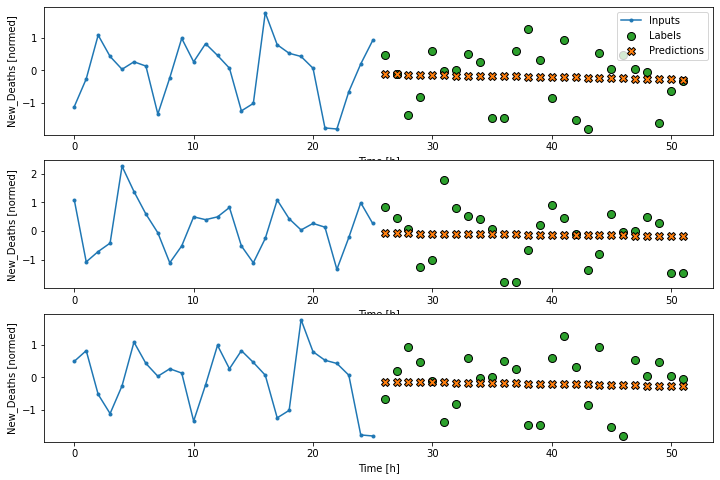

In [42]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = np.unique(df_all['Province_State'])
OUT_STEPS = 26
# max epoch is tune-able
MAX_EPOCH = 20
multi_val_performance = {}
multi_performance = {}

# change state name inside list
for state in ['California']:
    # extract state data from entire df
    statedata_all = df_all.loc[df_all['Province_State'] == state]
    statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
    
    # split into training, val, test sets
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(statedata)
    p = 26
    train_df = statedata[0:int(n - 2*p)]
    # contains second to last set of 26 dates, tune-able
    val_df = statedata[int(n - 2*p):int(n - p)]
    # contains last 26 dates, tune-able
    test_df = statedata[int(n - p):]
    
    # standardize
    num_features = statedata.shape[1]
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # create window, input_width is number of previous days to feed in, tune-able
    multi_window = WindowGenerator(input_width=26, label_width=OUT_STEPS, shift=OUT_STEPS, 
                               train_df = train_df, val_df = val_df, test_df = test_df)
    
    # init and train model, units is number of hidden nodes, tune-able
    feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
    history = compile_and_fit(feedback_model, multi_window, MAX_EPOCH)

    IPython.display.clear_output()

    multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
    multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
    # plot 3 random training performances
    multi_window.plot(feedback_model, plot_col = 'New_Deaths')
    
    # make predictions
    pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
    for i in range(len(pred)):
        pred[i] = pred[i] * train_std + train_mean
    
    # formatting
    pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
    df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
    df2 = df2.loc[df2['Province_State'] == state]
    
    # calculate MAPE for both confirmed and deaths
    mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
    mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])
    print(mape * 100)

### Make predictions for all states

In [47]:
import datetime
base = datetime.date(2020, 9, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(26)]
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%m/%d/%Y")
numdays = 26

In [48]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = np.unique(df_all['Province_State'])
OUT_STEPS = 26
MAX_EPOCH = 20
predictions = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed', 'Deaths'])

for state in statenames:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    statedata_all = df_all.loc[df_all['Province_State'] == state]
    statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
    
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(statedata)
    p = 26
    train_df = statedata[0:int(n - 2*p)]
    val_df = statedata[int(n - 2*p):int(n - p)]
    test_df = statedata[int(n - p):]

    num_features = statedata.shape[1]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    multi_window = WindowGenerator(input_width=26, label_width=OUT_STEPS, shift=OUT_STEPS, 
                               train_df = train_df, val_df = val_df, test_df = test_df)
    
    feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
    history = compile_and_fit(feedback_model, multi_window, MAX_EPOCH)

    IPython.display.clear_output()

    multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
    multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
    
    pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
    for i in range(len(pred)):
        pred[i] = pred[i] * train_std + train_mean

    pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
    df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
    df2 = df2.loc[df2['Province_State'] == state]
    #print(pred)
    temp = pd.concat([temp, pd.DataFrame(pred, columns = ['Confirmed', 'Deaths'])], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed', 'Deaths']
    predictions = predictions.append(temp)
    #mape = np.absolute((pred[:,0] - df2['Confirmed'])) / np.array(df2['Confirmed'])
    mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
    mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])

In [49]:
# calculate total MAPE
test = pd.read_csv('cleaned_test.csv', index_col = 0)
test[['Confirmed', 'Deaths']]

pred2 = predictions
pred2 = pred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)
pred2 = pred2.drop(columns = ['Province_State', 'Date'])
pred2.index.name = 'ForecastID'
mape = np.absolute((pred2 - np.array(test[['Confirmed', 'Deaths']]))) / np.array(test[['Confirmed', 'Deaths']])
mape = np.sum(mape, axis = 0) / len(pred2)
mape

Confirmed    0.053070
Deaths       0.059673
dtype: float64

In [51]:
# calculate state MAPE
pred2 = predictions
pred2 = pred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)
temp = pd.read_csv('cleaned_test.csv', index_col = 0)

actual = temp[['Confirmed', 'Deaths']].reset_index(drop = True)
pred2['mapeConfirm'] = np.absolute(pred2[['Confirmed']] - actual[['Confirmed']]) / actual[['Confirmed']] * 100
pred2['mapeDeaths'] = np.absolute(pred2[['Deaths']] - actual[['Deaths']]) / actual[['Deaths']] * 100

pred2.groupby(by = 'Province_State').mean()

,Confirmed,Deaths,mapeConfirm,mapeDeaths
Province_State,,,,
Alabama,138120.923077,2312.730769,0.443230,1.478689
Alaska,5638.192308,41.384615,8.834359,4.016260
Arizona,221610.692308,5351.384615,5.957452,0.931894
Arkansas,69366.192308,858.576923,1.215981,15.123759
California,786029.769231,13771.384615,3.393667,3.811668
Colorado,60340.576923,2076.769231,2.186967,4.357779
Connecticut,53703.230769,4536.307692,1.582009,1.226548
Delaware,18270.615385,675.576923,2.519169,9.676786
Florida,614822.807692,11707.346154,7.039788,6.517586


In [ ]:
pred2.to_csv("Team1_LSTM.csv")

## Archived Code

We will add a parameter for the number of days since Jan 1st, which will eventually replace the timestamps.


In [ ]:
import datetime
# add a column for days since Jan 1st(will eventually remove timestamp)
# too lazy to vectorize
days = np.zeros(len(data.index))
for i in range(len(data.index)):
    days[i] = (data['Last_Update'][i].date() - datetime.date(2020, 1, 1)).days
data['days'] = days

data.head()